In [88]:
import os.path
import sys

import os

# Récupère le chemin d'accès parent de sys.path[0]
parent_dir = os.path.dirname(sys.path[0])

sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa
import bisect

## L'implimentation d'un systeme multi agent qui suit le Protocole AMI

In [89]:
def nombre_arc_different(route1,route2):
    arcs_voiture1 = set()
    for sous_route in route1:
        sous_route = [0]+sous_route+[0]
        arcs_voiture1.update(set(zip(sous_route, sous_route[1:])))

    arcs_voiture2 = set()
    for sous_route in route2:
        sous_route = [0]+sous_route+[0]
        arcs_voiture2.update(set(zip(sous_route, sous_route[1:])))

    arcs_diff = arcs_voiture1.symmetric_difference(arcs_voiture2)

    return(len(arcs_diff))


## fonction de dispersion

In [90]:
def insert_solution(CS, NB, R, DT, MinEMP, EMP):
    # CS : solution courante à insérer dans l’EMP
    # NB : nombre des solutions dans l’EMP
    # R : nombre minimum des arcs différents pour considérer une solution comme différente
    # DT : niveau de diversité
    # MinEMP : le nombre minimum de solutions pouvant être incluses dans l’EMP
    # EMP : l’ensemble des solutions dans l'EMP

    d = 0  # le nombre de solutions dans l’EMP différent de CS
    
    for k in range(0, NB):
        # parcourir toutes les solutions dans l’EMP
         
        # le nombre des arcs différentes de solution numéro k dans l’EMP rapport à CS
        solution_k = EMP[k]

        lambda_slot = nombre_arc_different(CS,solution_k)
     
                        
        if lambda_slot >= R:
            # Si le nombre des arcs différents est supérieur ou égal à R, alors la solution est considérée différente de la solution k dans l'EMP
            d += 1
                    
        if lambda_slot == 0:
            # Si le nombre de créneaux différents est nul, alors la solution existe déjà dans l'EMP
            break
            #print("La solution existe déjà dans l'EMP")

    
    if d / NB >= DT:
        # Si le rapport entre le nombre de solutions différentes et le nombre total de solutions est supérieur ou égal à DT, alors on peut insérer la solution dans l'EMP si elle est meilleure que la pire solution dans l'EMP
        if cout(CS) < cout(EMP[-1]) or NB < MinEMP:
            EMP.pop(-1)
            EMP.append(CS)
            EMP = sorted(EMP,key = cout)
 

In [106]:
num_clients = 30

In [107]:
R = num_clients//3
DT = 0.4
MinEMP = 10

## Création des Agents

In [109]:
class Recuit_sem(mesa.Agent):
    
    # Création d'agent Recuit simulé 


    def __init__(self, model,parameters):
        
        super().__init__(self,model)
        self.parameters = parameters
        self.history = []

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Recuit simulé
        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _  = recuit_simule(self.model.Pool[solution_index],self.parameters['temperature_initiale'] , self.parameters['temperature_finale'],alpha=0.99)
        insert_solution(new_solution, len(self.model.Pool), R, DT, MinEMP, self.model.Pool)
        #self.model.Pool[solution_index] = new_solution

            
    def step(self):
        
        self.execute()

In [110]:
class Tabou(mesa.Agent):
    
    # Création d'agent Tabou 

    def __init__(self,  model,parameters):
        super().__init__(self,model)
      
        self.parameters = parameters
        self.history = []
        self.initial_solution = None

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Tabou
        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _ = tabou(self.model.Pool[solution_index] ,self.parameters['taille_tabou'],self.parameters['max_iterations'],self.parameters['n_voisin'])
        insert_solution(new_solution, len(self.model.Pool), R, DT, MinEMP, self.model.Pool)
        #self.model.Pool[solution_index] = new_solution

            
    def step(self):
        self.execute()

In [111]:
class Genetic(mesa.Agent):
    
    # Création d'agent genetique 


    def __init__(self,  model,parameters):

        super().__init__(self,model)
        self.parameters = parameters


    def execute(self):

        # Prendre le Pool comme une population initial et la remplacer par une population améliorer par l'algo genetique
        new_solution, meilleure_valeur , _ ,population = genetique(self.model.Pool,self.parameters['taux_mutation'],self.parameters['max_iterations'])
        self.model.Pool = copy.deepcopy(population)

            
    def step(self):
        self.execute()

In [112]:
def compute_Pool_avg(model):
    
    # Calculer le cout moyenne des solutions dans le Pool
    couts = [cout(model.Pool[i]) for i in range(len(model.Pool))]
    return sum(couts)/len(couts)

def compute_Pool_min(model):
    
    # Calculer le cout minimum des solution dans le Pool
    couts = [cout(model.Pool[i]) for i in range(len(model.Pool))]

    return min(couts)

def get_the_best_solution(model):

    # Récupérer la meilleur solution dans le Pool
    couts = np.array([cout(model.Pool[i]) for i in range(len(model.Pool))])

    return model.Pool[np.argmin(couts)]

In [113]:
## Les paramètres des Algorithmes 
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-6 } , 'tabou' : {'taille_tabou' : 20 , 'max_iterations' : 100 , 'n_voisin' : 10} , 'genetic'  : {'taux_mutation' : 0.1 ,'max_iterations' : 200 }}

In [114]:
class SMA(mesa.Model):
    
    """Création d'environnement de communication entre les agents"""


    def __init__(self,Pool,parameters):
        
        self.schedule = mesa.time.RandomActivation(self)
        self.Pool = Pool
        

        # Instanciation des agents 
        self.optimazers = [Recuit_sem(self,parameters['rs']),Tabou(self,parameters['tabou'])]
        self.genetique_optimizer = Genetic(self,parameters['genetic'])

        for agent in self.optimazers : 
            self.schedule.add(agent)

        ## Récuperer à chaque step la meilleur solution dans le Pool et son cout
        self.datacollector = mesa.DataCollector(
            model_reporters={"pool_avg": compute_Pool_avg ,"best_pool": get_the_best_solution,"pool_min": compute_Pool_min } )


    def step(self):

        self.datacollector.collect(self)
        self.schedule.step()


In [117]:
## Création du Pool
Pool = []
list_client_initial = [i for i in range(num_clients)]
for j in range(15): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(get_route_version2(x,time_window, Q))

In [116]:
sma_env = SMA(Pool,parameters)

In [118]:
for i in range(150):

    # Amélioration de chaque solution par les algo Tabou / Récuit simuler
    sma_env.step()

    if i%10 == 1 :
    
        # Amélioration du Pool par l'algo genetique
        sma_env.genetique_optimizer.execute()
        sma_env.datacollector.collect(sma_env)
    

In [119]:
results = sma_env.datacollector.get_model_vars_dataframe()

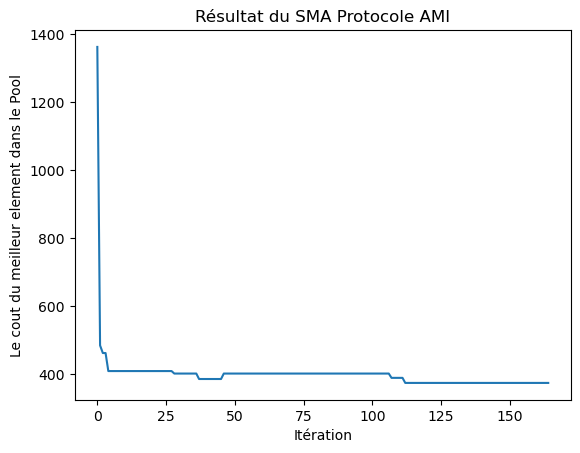

In [120]:
plt.plot(results['pool_min'])
plt.title("Résultat du SMA Protocole AMI")
plt.xlabel("Itération")
plt.ylabel("Le cout du meilleur element dans le Pool")
plt.savefig('Résultats/Résultat_sma_ami1')

In [121]:
print('The best solution is :' ,get_the_best_solution(sma_env))
print('With the cost :' , cout(get_the_best_solution(sma_env)))
print('The number of vehicle :' ,len(get_the_best_solution(sma_env)))

The best solution is : [[20, 24, 5, 27, 0, 23, 11, 10, 2, 28, 15, 1, 9, 21, 4, 29, 14, 3, 18, 26, 22, 12, 8, 16, 17], [19, 7, 13, 6, 25]]
With the cost : 373.8250590261142
The number of vehicle : 2


In [28]:
import folium

def tracer_segments_folium(L,color,m):
    # Créer une carte centrée sur le premier point de la liste

    # Ajouter des marqueurs pour chaque point de la liste
    for c in L:

        folium.Marker(location=c).add_to(m)

    # Ajouter une Polyline reliant les marqueurs
    folium.PolyLine(locations=L, color=color).add_to(m)

    # Afficher la carte


def plot_solution(solution):

    m = folium.Map(location=(0,0), zoom_start=12)
    K = len(solution)
    k = 0
    color = ['red' , 'blue' , 'green', 'yellow']
    for vehicule in solution : 

        L = [(data_client_index['CUSTOMER_LATITUDE'].iloc[k] , data_client_index['CUSTOMER_LONGITUDE'].iloc[k]) for k in range(len(vehicule))]
        tracer_segments_folium(L,color[k],m)
        k = k + 1
    m.save('Résultats/solution_ploted_test.html')


In [29]:
plot_solution(get_the_best_solution(sma_env))